In [2]:
import traceback
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from WF_SDK import device
from WF_SDK import scope
from WF_SDK import wavegen

%matplotlib inline

In [3]:
class ADSHardware():
    """Class of functions for interfacing with the ADS.
    """

    def __init__(self):
        self.handle = None

    def startup(self):
        """Connects to the ADS. Defines 'handle', the address to the ADS.
        Must be run at the beginning of every program using the ADS.
        """
        self.handle = device.open()

    def open_scope(self, buffer_size=1000, sample_freq=100e6):
        """Opens connection to the scope.

        Args:
            buffer_size (int, optional): How many data points are temporarily stored
            before being returned. The buffer is a temporary slot for storing a small amount of
            data before it is transferred to its final destination. Defaults to 1000.
            sample_freq (int, optional): How frequently the oscilloscope will sample
            from the input. Defaults to 100e6. You can decrease this if you have too
            many data points/the function is taking awhile to run for the time scale you need.
            (1e6 or even 16e3 can be reasonable selections.)
        """
        scope.open(self.handle, buffer_size=buffer_size, sampling_frequency=sample_freq)

    def trigger_scope(self, channel=1, level=0.1):
        """Sets trigger level for the scope. Kind of a buggy function; not used.

        Args:
            channel (int, optional): Selects which channel of scope to read out. 
            Defaults to 1.
            level (float, optional): Sets trigger level for scope. Defaults to 0.1.
        """
        scope.trigger(self.handle, enable=True, source=scope.trigger_source.analog, channel=channel,
                      edge_rising=True, level=level)

    def read_scope(self, channel=1):
        """Collects data from the scope.

        Args:
            channel (int, optional): Which channel to read from. Defaults to 1.

        Returns:
            buffer (array): An array of output data points. The buffer is a temporary slot 
            for storing a small amount of data before it is transferred to its final destination.
        """
        buffer = scope.record(self.handle, channel=channel)
        return buffer

    def close_scope(self):
        """Closes connection to the scope.
        """
        scope.close(self.handle)

    def use_wavegen(self, channel=1, function=wavegen.function.sine, offset_v=0, freq_hz=1e3, amp_v=1):
        """Runs the wavegen producing function with given parameters.

        Args:
            channel (int, optional): Which channel output is at. Defaults to 1.
            function (function object, optional): What type of function to output. 
            Defaults to wavegen.function.sine.
            offset (int, optional): Voltage offset (V). Defaults to 0.
            freq (int, optional): Frequency (Hz). Defaults to 1e3.
            amp (int, optional): Amplitude (V). Defaults to 1.
        """
        wavegen.generate(self.handle, channel=channel, function=function, offset=offset_v,
                         frequency=freq_hz, amplitude=amp_v)

    def close_wavegen(self):
        """Closes wavegen.
        """
        wavegen.close(self.handle)

    def disconnect(self):
        """Closes ADS connection. Must be run at the end of every program.
        """
        device.close(self.handle)

In [4]:
def oscilloscope_run(ads_object: ADSHardware, duration: int, channel: int, sampling_freq=500):
    """Collects data from the oscilloscope.

    Args:
        ads_object (ADSHardware object): the ADS being used
        duration (int): time length of trace to collect in seconds
        channel (int): which channel to collect data from
        sampling_freq (int, optional): How frequently the oscilloscope will sample (Hz)
        from the input. Defaults to 1e6. You can decrease this if you have too
        many data points/the function is taking awhile to run for the time scale you need.
        (16e3 can be a reasonable selection.)

    Returns:
        data (dict): has two keys, "x" and "y" which have time (ms) and voltage (V) data
    """
    buffer_size = int(duration * sampling_freq)
    data = {}
    ads_object.open_scope(sample_freq=sampling_freq, buffer_size=buffer_size)

    MS_CONVERSION = 1e3

    buffer = ads_object.read_scope()
    data["y"] = buffer

    #MODIFY THE LINE BELOW THIS ONE IN L10.2(d)
    t_sec = np.arange(buffer_size) / sampling_freq
    # convert to ms for the lab convention
    data["x"] = t_sec * MS_CONVERSION
    
    ads_object.close_scope()
    return data

In [5]:
def fft(data: dict, nonnegative=True, real=True):
    """Takes an FFT of input data.

    Args:
        data (dict): Provides x data in ms and y data in V obtained from oscilloscope.
        nonnegative: Whether to return only non-negative frequencies
        real: if True, returns the absolute values of the magnitudes
    Returns:
        fft_result (dict): a dictionary with two keys, "frequencies" and "magnitudes",
                            containing the frequencies and magnitudes from the FFT.
    """
    fft_result = {}
    #FILL IN THIS FUNCTION FOR L10.3(b) and L10.3(c)
    MS_CONVERSION = 1e3
    #avg_timestep below may be helpful for your call to np.fft.fftfreq...
    avg_timestep = np.mean(np.diff(data["x"])/MS_CONVERSION)

    y = np.array(data["y"])
    N = len(y)

    # FFT and frequencies
    Y = np.fft.fft(y)
    freqs = np.fft.fftfreq(N, d=avg_timestep)

    # Magnitude (Volts) – normalize by N so amplitude is sensible
    mags = np.abs(Y) / N

    # Keep only non-negative frequencies
    mask = freqs >= 0
    fft_result["frequencies"] = freqs[mask]
    fft_result["magnitudes"] = mags[mask]

    return fft_result

In [6]:
def butter_lowpass_filter(data, cutoff: float, fs: float, order=5):
    """Creates and applies a lowpass filter.

    Args:
        data (list): Provides y data in V obtained from oscilloscope.
        cutoff (float): 3 dB frequency (Hz) for low pass filter.
        fs (float): Sampling frequency data was taken at.
        order (int, optional): Order of the filter. Defaults to 5.

    Returns:
        list: Low pass filtered data in V.
    """
    # Define lowpass filter coefficients using butter function in scipy.signal package
    b, a = sig.butter(order, cutoff, btype='lowpass', analog=False, fs=fs, output='ba')
    # Applies lowpass filter using scipy.signal.filtfilt function
    y = sig.filtfilt(b, a, data)
    return y

In [7]:
def demodulate_radio(data: dict, nu_3db: float = 2, save=True):
    """Demodulate signal using the strategy we used for the AM radio.
    That is, first subtract the mean of the data, then do a lowpass filter.

    Args:
        data (dict): Provides x data in ms and y data in V obtained from oscilloscope.
        nu (float): 3 dB frequency (Hz) for low pass filter.
        save (bool, optional): Whether or not to save data to file. Defaults to True.

    Returns:
        demod_data (dict): has two keys, "x" and "y" which have time (ms) and voltage (V) data
    """
    demod_data = {}
    demod_data["x"] = data["x"]
    MILLISECOND_CONVERSION = 1e3

    #calculates average sampling frequency for digital filter
    fs = len(data["x"] - 1)*MILLISECOND_CONVERSION / (data["x"][-1] - data["x"][0])

    #FILL IN THESE LINES FOR L10.5(b)
    dc_offset_remove = np.array(data['y']) - np.mean(np.array(data['y'])) #remove dc offset
    rectified_data = np.abs(dc_offset_remove) #rectify
    demod_data["y"] = butter_lowpass_filter(rectified_data, nu_3db, fs) #low pass

    #plot the different steps
    fig, axs = plt.subplots(2, 2)
    axs[0, 0].plot(demod_data["x"], data["y"])
    axs[0, 0].set_title('Raw Signal (Vout)')
    axs[0, 1].plot(demod_data["x"], dc_offset_remove, 'tab:orange')
    axs[0, 1].set_title('DC Offset Removed')
    axs[1, 0].plot(demod_data["x"], rectified_data, 'tab:green')
    axs[1, 0].set_title('Rectified (Vout1)')
    axs[1, 1].plot(demod_data["x"], demod_data["y"], 'tab:red')
    axs[1, 1].set_title('Low Pass Filtered (Vout2)')

    for ax in axs.flat:
        ax.set(xlabel='Time (ms)', ylabel='Voltage (V)')
        ax.grid(visible=True, which='major', color='black', linestyle='-')
        ax.grid(visible=True, which='minor', color='black', linestyle='--')
    
    for ax in axs.flat:
        ax.label_outer()
    
    plt.show()

    #save the data if desired
    if save:
        fname = os.path.join('./heartbeat_data', 'demod_lockin'+time.strftime("%Y%m%d-%H%M%S")+".txt")
        save_array = np.array([demod_data["x"], demod_data["y"]])
        np.savetxt(fname, save_array)

    return demod_data

In [8]:
def demodulate_lockin(ads_object: ADSHardware, nu_mod: float, nu_3db: float, duration=5, channel=1, save=True):
    """Demodulate signal the way a lock in amplifier would, taking advantage
    of the fact that we can phase match.

    Args:
        ads_object (ADSHardware): the ADS being used.
        nu_mod (float): Modulation frequency (Hz). 100 recommended starting point.
        nu_3db (float): 3 dB frequency for low pass (Hz).
        duration (int, optional): Number of seconds to record for. Defaults to 5.
        channel (int, optional): Channel to read oscilloscope on. Defaults to 1.
        save (bool, optional): Whether or not to save data to file. Defaults to True.

    Returns:
        dict: _description_
    """
    MILLISECOND_CONVERSION = 1e3
    omega = 2*np.pi*nu_mod

    #we have to start the wavegen and oscilloscope read right after each other
    #in order to achieve phase locking
    test = ads_object.use_wavegen(channel=1, 
                    function=wavegen_functions["sine"], 
                    offset_v=2.75, 
                    freq_hz=nu_mod, 
                    amp_v=1)
    data = oscilloscope_run(ads_object, channel=channel, duration=duration)
    ads_object.close_wavegen()

    #calculates average sampling frequency for digital filter
    fs = len(data["x"] - 1)*MILLISECOND_CONVERSION / (data["x"][-1] - data["x"][0])

    demodulated_data = {}
    demodulated_data["x"] = data["x"]

    #calculate the cos and sin components of the local oscillator
    #i.e. what is being produced by wavegen
    demodulated_data["local_oscillator_cos"] = np.cos(omega*data["x"]/MILLISECOND_CONVERSION)
    demodulated_data["local_oscillator_sin"] = np.sin(omega*data["x"]/MILLISECOND_CONVERSION)

    #FILL IN THE BLANKS BELOW FOR L10.6(a)
    #finds the cos and sin components of the signal read on the scope
    demodulated_data["sin"] = demodulated_data["local_oscillator_sin"] * np.array(data['y'])
    demodulated_data["cos"] = demodulated_data["local_oscillator_cos"] * np.array(data['y'])

    #low pass filters the data
    demodulated_data["lowpass_sin"] = butter_lowpass_filter(demodulated_data['sin'], nu_3db, fs)
    demodulated_data["lowpass_cos"] = butter_lowpass_filter(demodulated_data['cos'], nu_3db, fs)


    #adds sin and cos components in quadrature to obtain the demodulated signal
    demodulated_data["y"] = np.sqrt(demodulated_data["lowpass_cos"]**2 + demodulated_data["lowpass_sin"]**2)

    #plot the steps to get demodulated signal
    fig, axs = plt.subplots(2, 2)
    axs[0, 0].plot(demodulated_data["x"], data["y"])
    axs[0, 0].set_title('Raw Signal')
    axs[0, 1].plot(demodulated_data["x"], demodulated_data["sin"], 'tab:orange')
    axs[0, 1].plot(demodulated_data["x"], demodulated_data["cos"], 'tab:green')
    axs[0, 1].set_title('Sin & Cos components')
    axs[1, 0].plot(demodulated_data["x"], demodulated_data["local_oscillator_cos"])
    axs[1, 0].plot(demodulated_data["x"], demodulated_data["local_oscillator_sin"])
    axs[1, 0].set_title('Local oscillator')
    axs[1, 1].plot(demodulated_data["x"], demodulated_data["lowpass_cos"])
    axs[1, 1].plot(demodulated_data["x"], demodulated_data["lowpass_sin"])
    axs[1, 1].set_title("Filtered sin & cos components")

    for ax in axs.flat:
        ax.set(xlabel='Time (ms)', ylabel='Voltage (V)')
        ax.grid(visible=True, which='major', color='black', linestyle='-')
        ax.grid(visible=True, which='minor', color='black', linestyle='--')
    
    for ax in axs.flat:
        ax.label_outer()
    
    plt.show()

    #plot the final demodulated signal
    plt.plot(demodulated_data["x"], demodulated_data["y"])
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (V)")
    plt.show()

    #save the data if desired
    if save:
        fname = os.path.join('./heartbeat_data', 'demod_lockin'+time.strftime("%Y%m%d-%H%M%S")+".txt")
        save_array = np.array([demodulated_data["x"], demodulated_data["y"]])
        np.savetxt(fname, save_array)

    return demodulated_data

In [9]:
wavegen_functions = {"sine":wavegen.function.sine, "square":wavegen.function.square,
                     "triangle":wavegen.function.triangle, "dc":wavegen.function.dc}

In [10]:
ads = ADSHardware()
ads.startup()

In [29]:
ads.use_wavegen(channel=1, function=wavegen_functions["sine"], offset_v=0, freq_hz=2, amp_v=2)
### FILL IN THIS LINE FOR L10.2(a)
raw_data = oscilloscope_run(ads, 10, 1)
ads.close_wavegen()

In [30]:
### UNCOMMENT THIS CODE FOR L10.3(a)
fft_result = fft(raw_data, nonnegative=True, real=True)

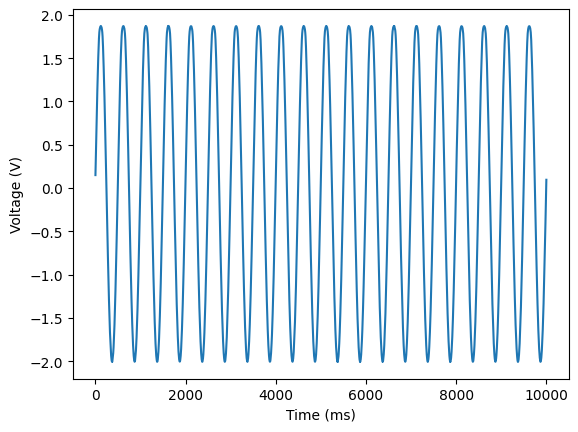

In [31]:
### UNCOMMENT THIS CODE FOR L10.2(b)
plt.plot(raw_data["x"], raw_data["y"])
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.show()

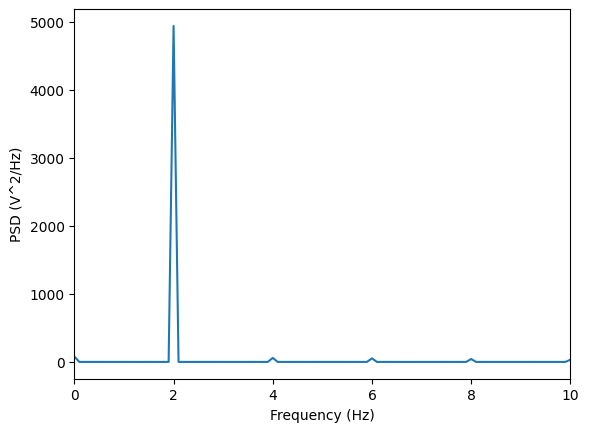

In [33]:
### PLOT YOUR DATA HERE FOR L10.3(d) 

fft_result = fft(raw_data, nonnegative=True, real=True)

plt.plot(fft_result["frequencies"], fft_result["magnitudes"])
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.xlim([0, 10])
plt.show()

In [39]:
ads.use_wavegen(channel=1,
                        function=wavegen_functions["sine"],
                        offset_v=2.75, freq_hz=1000, amp_v=1)

In [40]:
ads.close_wavegen()

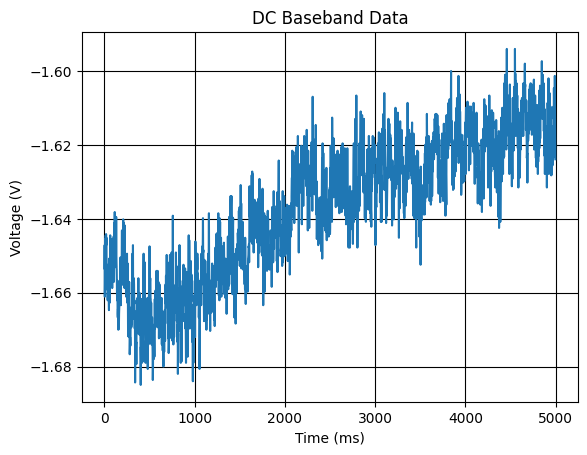

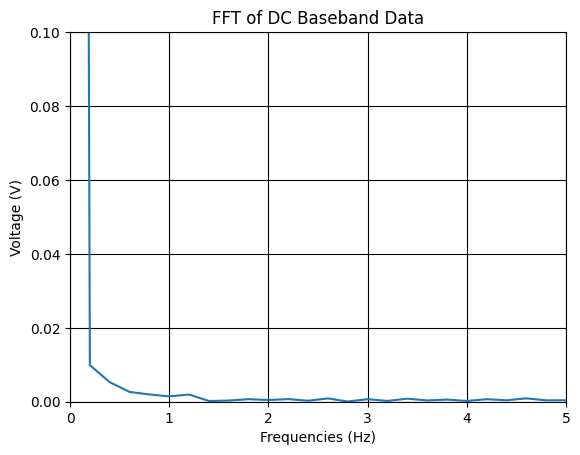

In [45]:
### DC BASEBAND - FOR L10.5(b)
ads.use_wavegen(channel=1,
                        function=wavegen_functions["dc"],
                        offset_v=2)
time.sleep(1) #so everything can 'settle' before data is collected

dc_baseband_data = oscilloscope_run(ads, duration=5, channel=1)

plt.plot(dc_baseband_data["x"], dc_baseband_data["y"])
plt.grid(visible=True, which='major', color='black', linestyle='-')
plt.grid(visible=True, which='minor', color='black', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.title("DC Baseband Data")
plt.show()

fname = os.path.join('./heartbeat_data', 'demod_lockin'+time.strftime("%Y%m%d-%H%M%S")+".txt")
np.savetxt(fname, np.array([dc_baseband_data["x"], dc_baseband_data["y"]]))

fft_dc_baseband = fft(dc_baseband_data)

plt.plot(fft_dc_baseband["frequencies"], fft_dc_baseband["magnitudes"])
plt.xlabel("Frequencies (Hz)")
plt.xlim([0, 5])
plt.ylim([0, 0.1])
plt.ylabel("Voltage (V)")
plt.grid(visible=True, which='major', color='black', linestyle='-')
plt.grid(visible=True, which='minor', color='black', linestyle='--')
plt.title("FFT of DC Baseband Data")
plt.show()

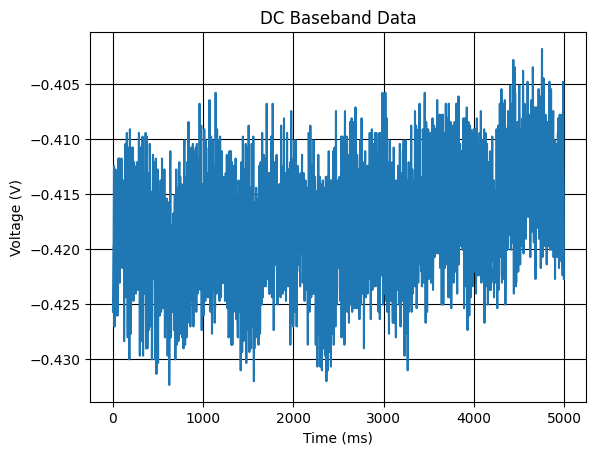

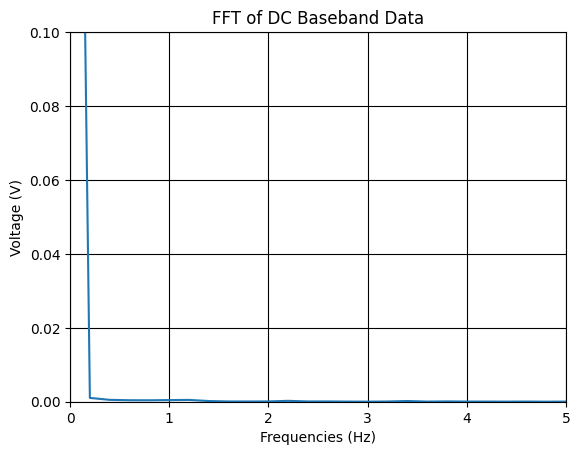

In [19]:
### DC BASEBAND - FOR L10.5(b)
ads.use_wavegen(channel=1,
                        function=wavegen_functions["dc"],
                        offset_v=2)
time.sleep(1) #so everything can 'settle' before data is collected

dc_baseband_data = oscilloscope_run(ads, duration=5, channel=1)

plt.plot(dc_baseband_data["x"], dc_baseband_data["y"])
plt.grid(visible=True, which='major', color='black', linestyle='-')
plt.grid(visible=True, which='minor', color='black', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.title("DC Baseband Data")
plt.show()

fname = os.path.join('./heartbeat_data', 'demod_lockin'+time.strftime("%Y%m%d-%H%M%S")+".txt")
np.savetxt(fname, np.array([dc_baseband_data["x"], dc_baseband_data["y"]]))

fft_dc_baseband = fft(dc_baseband_data)

plt.plot(fft_dc_baseband["frequencies"], fft_dc_baseband["magnitudes"])
plt.xlabel("Frequencies (Hz)")
plt.xlim([0, 5])
plt.ylim([0, 0.1])
plt.ylabel("Voltage (V)")
plt.grid(visible=True, which='major', color='black', linestyle='-')
plt.grid(visible=True, which='minor', color='black', linestyle='--')
plt.title("FFT of DC Baseband Data")
plt.show()

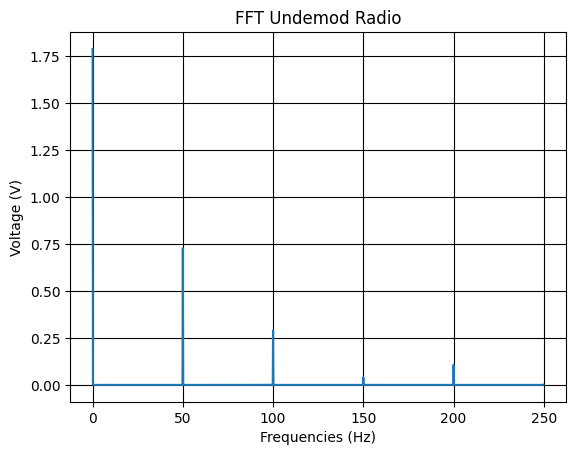

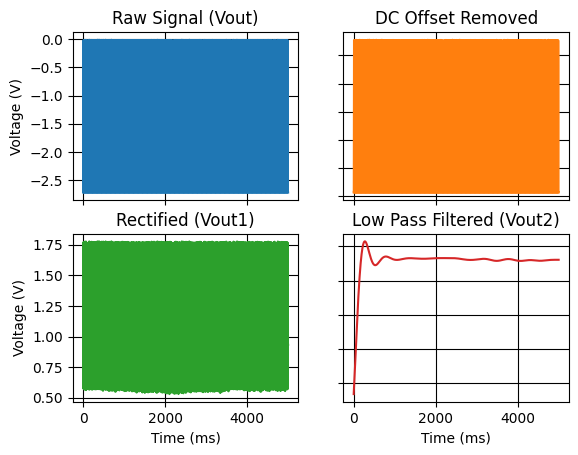

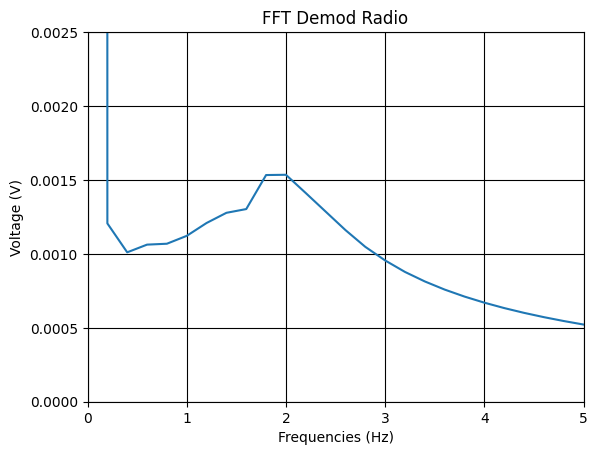

In [12]:
### FOR L10.5(f) - fill in nu_3db!
ads.use_wavegen(channel=1,
                        function=wavegen_functions["sine"],
                        freq_hz=50, amp_v=1, offset_v=2.75)

raw_data = oscilloscope_run(ads, duration=5, channel=1)

fft_demod_radio = fft(raw_data)
plt.plot(fft_demod_radio["frequencies"], fft_demod_radio["magnitudes"])
plt.xlabel("Frequencies (Hz)")
plt.ylabel("Voltage (V)")
plt.grid(visible=True, which='major', color='black', linestyle='-')
plt.grid(visible=True, which='minor', color='black', linestyle='--')
plt.title("FFT Undemod Radio")
plt.show()

demod_data_radio = demodulate_radio(raw_data, nu_3db=2)
fft_demod_radio = fft(demod_data_radio)
plt.plot(fft_demod_radio["frequencies"], fft_demod_radio["magnitudes"])
plt.xlabel("Frequencies (Hz)")
plt.ylabel("Voltage (V)")
plt.xlim([0, 5])
plt.ylim([0, 0.0025])
plt.grid(visible=True, which='major', color='black', linestyle='-')
plt.grid(visible=True, which='minor', color='black', linestyle='--')
plt.title("FFT Demod Radio")
plt.show()

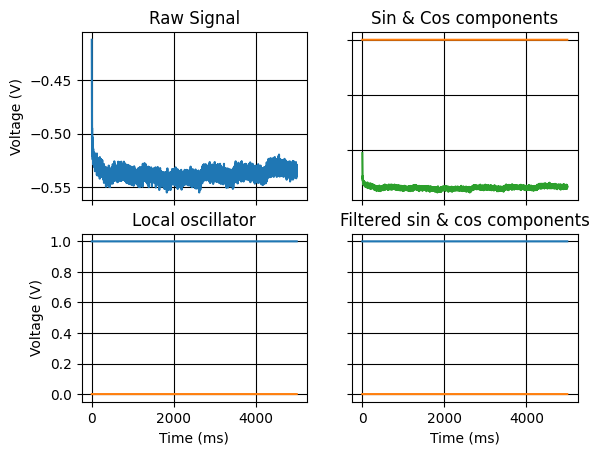

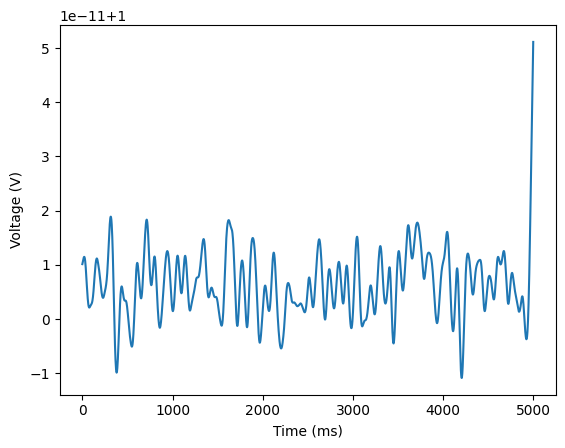

In [25]:
### DEMOD LOCKIN - FOR L10.6(b)
demod_data_lockin = demodulate_lockin(ads, duration=5, nu_mod=1000, nu_3db=10)

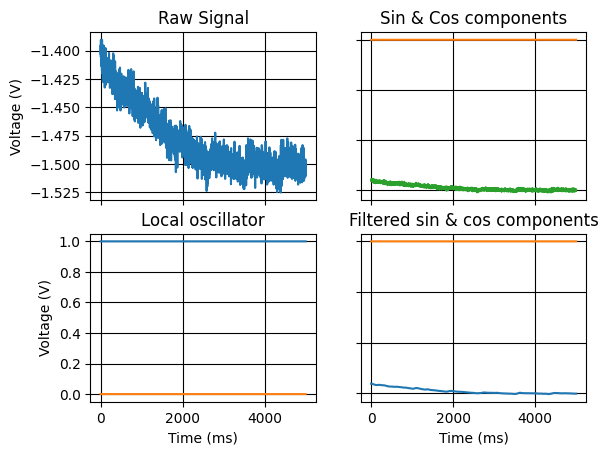

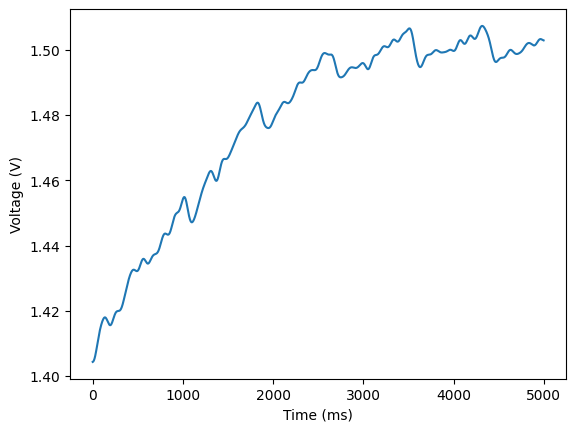

In [66]:
### DEMOD LOCKIN - FOR L10.6(b)
demod_data_lockin = demodulate_lockin(ads, duration=5, nu_mod=1000, nu_3db=10)

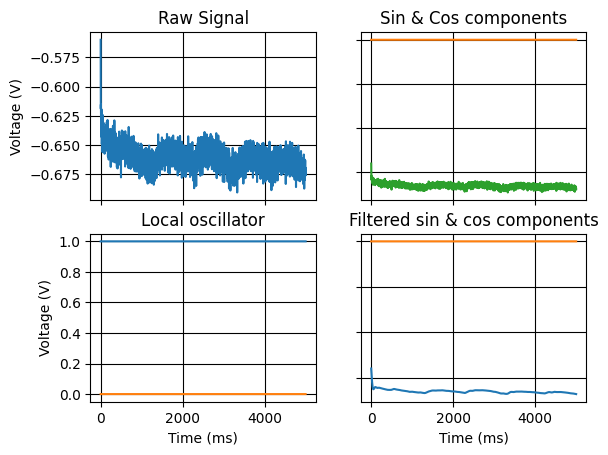

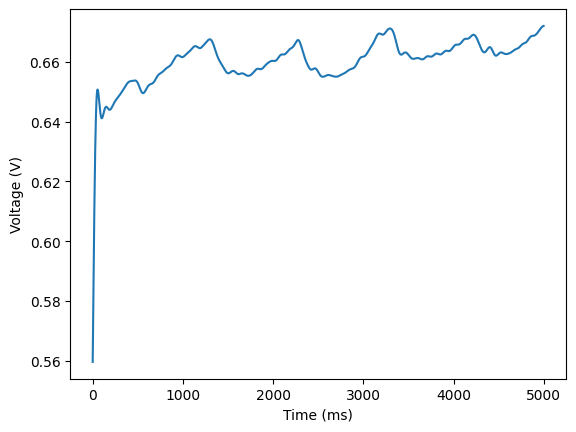

In [17]:
### DEMOD LOCKIN - FOR L10.6(b)
demod_data_lockin = demodulate_lockin(ads, duration=5, nu_mod=1000, nu_3db=10)

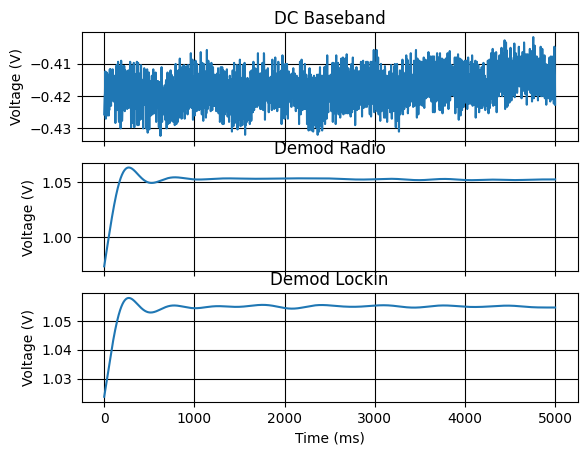

In [20]:
#if you want to use data from a different run, uncomment the following lines
# dc_baseband_data["x"], dc_baseband_data["y"] = np.loadtxt("C:/Users/kaija/repos/111a_lab10/heartbeat_data/demod_lockin20251120-162912.txt")
# demod_data_radio["x"], demod_data_radio["y"] = np.loadtxt("C:/Users/kaija/repos/111a_lab10/heartbeat_data/demod_lockin20251120-162912.txt")
demod_data_lockin["x"], demod_data_lockin["y"] = np.loadtxt("C:/Users/kaija/repos/111a_lab10/heartbeat_data/demod_lockin20251120-162912.txt")

# APPROACH COMPARISON - FOR L10.6(c)
fig, axs = plt.subplots(3, 1)
axs[0].plot(dc_baseband_data["x"], dc_baseband_data["y"])
axs[0].set_title("DC Baseband")
axs[1].plot(demod_data_radio["x"], demod_data_radio["y"])
axs[1].set_title("Demod Radio")
axs[2].plot(demod_data_lockin["x"], demod_data_lockin["y"])
axs[2].set_title("Demod Lockin")

for ax in axs.flat:
    ax.set(xlabel='Time (ms)', ylabel='Voltage (V)')
    ax.grid(visible=True, which='major', color='black', linestyle='-')
    ax.grid(visible=True, which='minor', color='black', linestyle='--')

for ax in axs.flat:
    ax.label_outer()

plt.show()

In [ ]:
#Only run this cell if your code errored in the middle of oscilloscope_run()
ads.close_scope()

In [ ]:
#Run this cell at the end of every test
ads.close_wavegen()
ads.disconnect()